# Data separation

## Compressed sensing 

Mohamed BOUSSENA and Ngoc-Tam Le

This project is based on the following article : 
Data Separation by Sparse Representations, Gitta Kutyniok, 2011

https://arxiv.org/pdf/1102.4527.pdf

## Theoretical results
___

The data separation problem is set as follow : Given a vector $x \in \mathcal{H}$ (where $\mathcal{H}$ is assumed to be a Hilbert space) such that $x = x_1 + x_2$, we would like to extract the two components $x_1$ and $x_2$. A general idea underlying data separation is to choose two basis representation $\Phi_1$ and $\Phi_2$ such that $x_1$ and $x_2$ can be represented in a sparse way in one of the two basis basis. Precisely, we would like to choose the basis such that $x_1$ is sparse in $\Phi_1$ and not $\Phi_2$, and vice versa. 

__Definition__ (mutual coherence) : Given a frame $\Phi$ on a Hilbert space $\mathcal{H}$, we define the mutual coherence for $\Phi$ by :

\begin{equation*}
    \mu(\Phi) = \underset{i,j \in I, i \neq j}{max}  \left| \langle \phi_i, \phi_j \rangle \right|
\end{equation*}
___

The following result gives us the guarantee that solving $l_1$ minimisation is equivalent to the $l_0$ minimisation.

__Theorem 1__: Let $\Phi_1$ and $\Phi_2$ two frames on a Hilbert space $\mathcal{H}$, and $x \in \mathcal{H} \backslash \{0\}$. Then if $x = \left[\Phi_1 \middle| \Phi_2 \right] c$ and 
    
$$\|c \|_0 \leq \frac{1}{2} \left(1 + \frac{1}{\mu\left(\left[\Phi_1 \middle| \Phi_2 \right]\right)} \right)$$

Then the solution of the $l_1$ minimization problem coincide with the solution of the $l_0$ minimization problem.
___

We want to solve the following program :


$$\underset{c_1, c_2}{min}\hspace{0.3cm} \|c_1 \|_1 + \|c_2\|_1$$
$$s.t. x = \left[\Phi_1 \middle|  \Phi_2 \right] \begin{bmatrix}c_1 \\ c_2 \end{bmatrix} $$

The constraint can be rewritten 

We can rewrite it as a linear program

$$min \ \mathbb{1}^T ( c_1^{+} + c_2^{+} + c_1^{-} + c_2^{-}) $$

$$ s.t \hspace{1cm} 
\begin{aligned}
\begin{bmatrix} \Phi_1 & \Phi_2 & -\Phi_1 & -\Phi_2 \end{bmatrix} \begin{bmatrix} c_1\\ c_2 \\ c_1^{-} \\ c_2^{-} \end{bmatrix} = x\\
0 \leq c_i^{+}, 0 \leq c_i^{-}, i=1, 2
\end{aligned}$$

## Application

In [2]:
# required libraries
import cvxpy as cp
import scipy.fftpack as spfft
import numpy as np
from PIL import Image
import time
import matplotlib.pyplot as plt

In [3]:
# solve l1 minimization problem and compute mutual coherence
class DataSep():
    
    def __init__(self, basis1, basis2, x):
        self.basis1 = basis1 # ndarray of size n * d1
        self.basis2 = basis2 # ndarray of size n * d2
        self.x = x # 1d array of size n 
        
    def coherence(self, phi):
        """
        compute the mutual coherence on a frame phi
        """
        mu = np.max( np.dot(phi.T, phi))
        return mu
    
    def get_sparse_component(self):
        """
        solve the basis pursuit program
        """
        A = np.hstack((self.basis1, self.basis2, -self.basis1, -self.basis2))
        b = self.x
        dim = A.shape[1]
        c = cp.Variable(dim)
        constraints = [A*c==b, 
                      c>=0]
        # define objective function
        obj = cp.Minimize(cp.norm(c, 1))
        prob = cp.Problem(obj, constraints)
        sol = prob.solve(verbose=True)
        
        # separate the two components
        b1_len, b2_len = basis1.shape[1], basis2.shape[1]
        sparse_comp = np.array(c.value)
        sparse_comp1 = sparse_comp[:b1_len] - sparse_comp[b1_len+b2_len: b2_len+2*b1_len]
        sparse_comp2 = sparse_comp[b1_len: b1_len+b2_len] - sparse_comp[b2_len+2*b1_len: ]
        
        return sparse_comp1, sparse_comp2

### Sinus and spike separation

We apply the method to impulse noise removal in 1-dimensional signal. An useful application of this problem is for instance audio declicking.

First, we need to build the frames $\Phi_1$, $\Phi_2$. We will use cosine and dirac basis, with the intuition that the principal source would be sparse in the cosine basis and the impulse noise would be sparse in the dirac basis.

Python package doesn't provide the cosine basis matrix but we can retrieve it from the inverse cosine transform function. To build $\Phi_1$ we use the inverse cosine transform, an apply it to the identity matrix. Let $x \in \mathbb{R}^n$. We have for all $x \in \mathbb{R}^n$, $DCT(x) = D_n x$ where $D_n = DCT(Id_n)$ DCT being computed along the first axis. If $x_1 = \Phi_1 c_1$, then $\Phi_1 = D_n^{-1}= D_n^T$.


$\Phi_2$ is just equal to the identity matrix.

In [61]:
# build phi1 phi2
# number of sample and spikes
n = 400
basis1 = spfft.idct(np.identity(n), norm='ortho', axis=0)
basis2 = np.eye(n)

#### Test on simulated data 

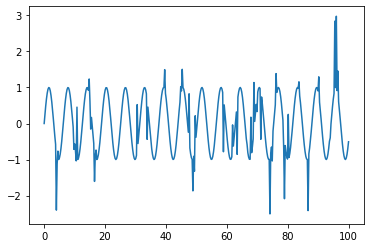

In [62]:
#number of spike 
m = 40

z = np.linspace(0, 100, n)
x = np.sin(z)

# spikes :
amplitude = 1
spike_index = np.random.choice(n, m, replace=False)
spike = np.zeros(n)
spike[spike_index] += amplitude * np.random.randn(m)

x += spike
plt.plot(z, x)

In [63]:
# solve the l1 minimisation problem 
one_dim = DataSep(basis1, basis2, x)

In [64]:
sparse_comp1, sparse_comp2 = one_dim.get_sparse_component()


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +2e+04  1e+00  7e-01  1e+00  5e+00    ---    ---    1  1  - |  -  - 
 1  +7.179e+01  +7.353e+01  +2e+04  7e-01  4e-01  2e+00  4e+00  0.3385  5e-01   0  0  0 |  0  0
 2  +6.903e+01  +7.149e+01  +1e+04  3e-01  1e-01  3e+00  2e+00  0.6421  3e-01   0  0  0 |  0  0
 3  +7.593e+01  +7.704e+01  +5e+03  1e-01  5e-02  1e+00  9e-01  0.6044  1e-01   1  0  0 |  0  0
 4  +7.848e+01  +7.882e+01  +2e+03  4e-02  2e-02  4e-01  4e-01  0.7053  1e-01   1  0  0 |  0  0
 5  +7.974e+01  +7.985e+01  +6e+02  1e-02  5e-03  1e-01  1e-01  0.6932  7e-02   1  0  0 |  0  0
 6  +8.021e+01  +8.027e+01  +3e+02  8e-03  3e-03  6e-02  7e-02  0.5126  1e-01   1  0  0 |  0  0
 7  +8.053e+01  +8.055e+01  +2e+02  4e-03  1e-03  3e-02  3e-02  0.5662  1e-01   1  0  0 |  0  0
 8  +8.064e+01  +8.065e+01  +7e+01  1e-03  6e-

In [65]:
x1 = np.dot(basis1, sparse_comp1) 
x2 = np.dot(basis2, sparse_comp2)

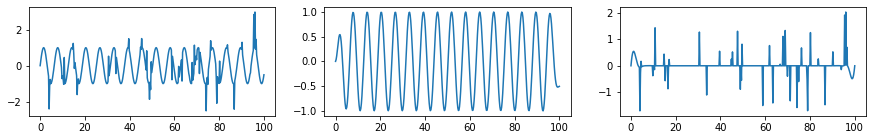

In [66]:

plt.figure(figsize = (15, 2))
plt.subplot(1,3,1)
plt.plot(z, x)
plt.subplot(1,3,2)
plt.plot(z, x1)
plt.subplot(1,3,3)
plt.plot(z, x2)

Due to the signal length, we observe some anomaly at the beginning. It's because the signal length doesn't match the period condition of the cosine transform. However, the sinusoid and the spikes seem to be separated properly.

With these basis, the mutual coherence is equal to $\sqrt{\frac{2}{n}}$. Allowed sparsity can be calculated with the theorem 1.

In [10]:
print('Allowed sparsity')
print( (1 + 1 / one_dim.coherence(np.hstack((basis1, basis2))) )/2)

Allowed sparsity
0.9999999999999988


In [136]:
20/2

10.0

In [137]:
one_dim.coherence(np.hstack((basis1, basis2)))

1.0000000000000024

### Image reconstruction with Cosine and Dirac basis

We would like to apply the method to reconstruct corrupted image. We make the assumption that given a image vector $x$, $x = x_1 + x_2$ such that $x_1$ represent the entire image, and $x_2$ is a term of noise that is sparse in the Dirac basis. 

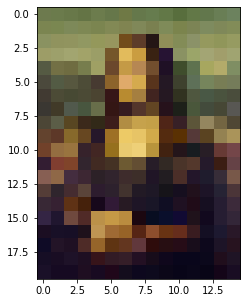

In [15]:
# import image 
img = Image.open('joconde.jpeg').resize((15,20))

plt.figure(figsize = (5,5))
plt.imshow(img, cmap=plt.cm.gray)

In [27]:
# Get gray scale array
img = np.array(img)
gray =  0.2989 * np.array(img)[:, :, 0] + 0.5870 * np.array(img)[:, :, 1] + 0.1140 * np.array(img)[: , :, 2]
print('Image shape:'+ str(gray.shape))

# Erase some samples 
n = gray.shape[0]
m = gray.shape[1]
index = np.arange(n*m)
np.random.shuffle(index)
erase = index[:n*m // 10]
gray = gray.flatten()
gray[erase] = 0
gray = gray.reshape(n, m)

Image shape:(20, 15)


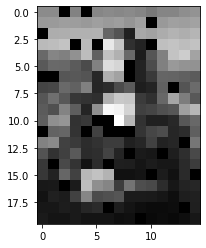

In [28]:
plt.imshow(gray, cmap=plt.cm.gray)

#### Build Cosine and Dirac frames
For the 2-dimensional problem, We build $\Phi_1$ and $\Phi_2$ Parseval frames, here corresponding to cosine and dirac basis.

We define the operator vec such that for $X \in \mathbb{R}^{n \times m}$, $vec(X)$ is the vector obtained by stacking the columns of $x$. 

Let $X \in \mathbb{R^{n \times m}}$. The 2-dimensional cosine transform is computed  from the 1-dimensional cosine transform applied to the row and then, to the columns. We denote $DCT_d$ the d-dimensional discrete transform :

\begin{align*}
DCT_2(X) &= DCT_1(DCT_1(X)^T))^T \\
         &= (D_n(D_m X)^T)^T \\
         &= D_mXD_n^T
\end{align*}
Where $DCT_1$ is computed along the first axis and $D_n = DCT_1(Id_n), D_m = DCT_1(Id_m)$.


If $X$ is decomposed as $X = X_1 + X_2$, the first component is written $x_1 = vec(X_1) = \Phi_1 c_1$. We use a basic property of the operator $vec$ linked to the Kronecker product, that is : $vec(AXB) = (B^T \otimes A) vec(X) $ to get :

$$x_1 = vect(D_m^{-1}C_1(D_n^{-1})^T) = (D_n^{-1} \otimes D_m^{-1}) c_1$$

We take $\Phi_1 = (D_n^{-1} \otimes D_m^{-1}) = (D_n^{T} \otimes D_m^{T}) $.


To get $\Phi_2$, we just stack the flattened matrices of canonical base in $\mathbb{R}^{n \times m}$, so that $\Phi_2 = Id_{nm}$. 

It appears that this method is not really scalable due to the kronecker product complexity.

In [29]:
# image dimensions
n, m = gray.shape
# vec operation
x = (gray.T).flatten()

# define the two frames
basis1 = np.kron(
    spfft.idct(np.identity(n), norm='ortho', axis=0),
    spfft.idct(np.identity(m), norm='ortho', axis=0)
    )
basis2 = np.eye(n*m)

two_dim = DataSep(basis1, basis2, x)

In [30]:
sparse_comp1, sparse_comp2 = two_dim.get_sparse_component()


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+06  1e+00  7e-01  1e+00  4e+02    ---    ---    1  1  - |  -  - 
 1  +1.852e+03  +1.935e+03  +1e+06  8e-01  6e-01  8e+01  4e+02  0.2799  8e-01   0  0  0 |  0  0
 2  +7.765e+03  +8.027e+03  +9e+05  4e-01  2e-01  3e+02  2e+02  0.7598  6e-01   0  0  0 |  0  0
 3  +8.104e+03  +8.235e+03  +3e+05  1e-01  5e-02  1e+02  8e+01  0.7086  8e-02   1  0  0 |  0  0
 4  +9.367e+03  +9.413e+03  +1e+05  4e-02  2e-02  5e+01  3e+01  0.6603  8e-02   1  0  0 |  0  0
 5  +9.983e+03  +1.000e+04  +5e+04  2e-02  6e-03  2e+01  1e+01  0.6358  7e-02   1  0  0 |  0  0
 6  +1.022e+04  +1.023e+04  +2e+04  6e-03  2e-03  5e+00  5e+00  0.7419  2e-01   1  0  0 |  0  0
 7  +1.033e+04  +1.033e+04  +8e+03  3e-03  9e-04  2e+00  2e+00  0.6795  1e-01   1  0  0 |  0  0
 8  +1.038e+04  +1.038e+04  +3e+03  9e-04  3e-

In [39]:
x1 = np.dot(basis1, sparse_comp1) 
x2 = np.dot(basis2, sparse_comp2)

x1 = x1.reshape(m, n).T
x2 = x2.reshape(m, n).T

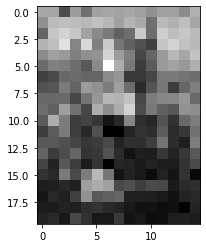

In [40]:
plt.imshow(x1, cmap=plt.cm.gray)